# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [279]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [280]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [281]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [282]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [283]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [284]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [285]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [286]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [287]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [288]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [289]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [290]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [291]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [292]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [293]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [294]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [295]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [296]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [297]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [298]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [299]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [300]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:28<00:00, 3127.15it/s]


In [301]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [302]:
## Similartly you can do preprocessing for review summary also
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:19<00:00, 4454.91it/s]


# Splitting data into train and test set

In [303]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(preprocessed_reviews,final['Score'],random_state=100,test_size=0.30,shuffle=False)

X_train2,X_CV,y_train2,y_CV = train_test_split(X_train,y_train,random_state=100,test_size=0.30,shuffle=False)

# [4] Featurization

## [4.1] BAG OF WORDS

In [304]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train2)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)
features_bow = count_vect.get_feature_names()
final_counts = count_vect.transform(X_train2)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

final_countsCV = count_vect.transform(X_CV)
final_countsTEST = count_vect.transform(X_test)

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaah', 'aaaah', 'aaaand', 'aachen', 'aadp']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (43008, 38816)
the number of unique words  38816


## [4.2] Bi-Grams and n-Grams.

In [305]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect2 = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
count_vect2.fit(X_train2)
print("some feature names ", count_vect2.get_feature_names()[:10])
print('='*50)

final_bigram_counts = count_vect2.transform(X_train2)

print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

final_bigram_countsCV = count_vect2.transform(X_CV)
final_bigram_countsTEST = count_vect2.transform(X_test)

some feature names  ['ability', 'able', 'able buy', 'able find', 'able get', 'able order', 'absolute', 'absolute favorite', 'absolutely', 'absolutely best']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (43008, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [306]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train2)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

features_tf_idf = tf_idf_vect.get_feature_names()

final_tf_idf = tf_idf_vect.transform(X_train2)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

final_tf_idfCV = tf_idf_vect.transform(X_CV)
final_tf_idfTEST = tf_idf_vect.transform(X_test)

some sample features(unique words in the corpus) ['abdominal', 'ability', 'able', 'able buy', 'able drink', 'able eat', 'able enjoy', 'able find', 'able finish', 'able get']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (43008, 24875)
the number of unique words including both unigrams and bigrams  24875


## [4.4] Word2Vec

In [307]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentence_train=[]
for sentence in X_train2:
    list_of_sentence_train.append(sentence.split())

In [308]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

w2v_model=Word2Vec(list_of_sentence_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  12442
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'infestation', 'literally', 'everywhere', 'flying', 'around', 'kitchen', 'bought', 'hoping', 'least', 'get', 'rid', 'weeks', 'fly', 'stuck', 'buggers', 'success', 'rate', 'day']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

#  Converting Train data text

In [309]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|███████████████████████████████████████████████████████████████████████████| 43008/43008 [01:33<00:00, 462.18it/s]


(43008, 50)
[-0.39133864  0.55263728  0.28874528 -0.25550993 -0.06088339 -0.6164806
 -0.21879564  1.04991286 -0.31347888  0.24922325 -0.64111702  0.13859355
  0.09690912  0.06331047  0.63735569 -0.42099862  0.26326944  0.76809363
 -0.24261065 -0.13325587 -0.34936061  0.2290425  -0.19650718  0.7991849
  0.37587467  0.44628108  0.38393394 -0.26650817 -0.3328966   0.25352922
  0.00889189 -0.01313225  0.05325747  0.45515439  0.06764127 -0.61015888
  0.15726464 -0.73799552 -0.3213911   0.96917496  0.20371024  0.27100417
  0.33530955 -0.57520408  0.40929473 -0.45530047 -1.01778779 -0.82428969
  0.11969408  0.00271046]


# ### Converting CV data text

In [310]:
i=0
list_of_sentence_cv=[]
for sentence in X_CV:
    list_of_sentence_cv.append(sentence.split())

# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|███████████████████████████████████████████████████████████████████████████| 18433/18433 [00:42<00:00, 431.95it/s]


(18433, 50)
[-2.63933516e-02 -1.28005787e+00  1.20813316e-02 -1.83735513e-01
  2.03166641e-02 -1.06850412e+00 -1.18400540e+00 -4.88664906e-01
  3.34206592e-01 -9.09020385e-01  7.73937472e-01 -4.91207178e-01
  4.93615807e-01  3.58841701e-01 -6.96271021e-01  2.96421821e-01
 -1.88636600e-01  6.77189998e-01 -9.86931958e-01  4.05644085e-01
 -7.43328871e-01  7.34000867e-01 -1.32761338e+00  3.20186147e-01
  1.22765924e+00  1.83398409e-01 -4.22884289e-01  4.37754916e-01
  5.87754156e-01 -1.85763510e+00 -6.81763273e-02 -4.19936757e-01
 -7.81100733e-01 -9.35069584e-01 -4.11027086e-01  8.02171053e-02
  2.15059392e-01  6.62756825e-01 -1.72195584e-03  8.52666002e-01
  4.68276941e-01  1.66118727e-01  5.21739815e-01 -2.52294266e-02
  8.89742789e-02 -3.69323724e-01 -6.17392757e-01 -7.33574548e-01
  3.69941217e-01  1.67685303e-01]


# Converting Test data text

In [311]:
i=0
list_of_sentence_test=[]
for sentence in X_test:
    list_of_sentence_test.append(sentence.split())

# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|███████████████████████████████████████████████████████████████████████████| 26332/26332 [01:02<00:00, 418.07it/s]


(26332, 50)
[-0.30684007  0.57278509  0.80906981  0.3271377   0.16455421 -1.82297001
  0.90163168  1.18598167  0.29724558  0.43784644  0.00753306  0.46952072
  0.736512    1.30084812  0.14433395 -0.22359537  0.13024589 -0.16678509
 -0.49315941  0.36696722 -1.23321886  1.06304763  0.33094535  1.14410553
  0.71923554  0.28452318 -0.41658925 -0.57907648 -0.78351411 -1.18119167
  0.32275283 -0.28501334  0.92763601  0.80701925  0.40664707 -1.92608179
  0.31072296  0.16267549 -0.27466978  1.31643019 -0.07630782  0.73415931
  0.4991471  -1.2158271   1.25535119  0.04220773 -0.06171494 -0.45876109
 -0.41747431 -1.24893588]


#### [4.4.1.2] TFIDF weighted W2v

In [312]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model_tf = TfidfVectorizer()
tf_idf_matrix = model_tf.fit_transform(X_train2)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model_tf.get_feature_names(), list(model_tf.idf_)))

# Calculating TFIDF weighted W2V for training data

In [313]:
# TF-IDF weighted Word2Vec
tfidf_feat = model_tf.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 43008/43008 [12:59<00:00, 55.20it/s]


# # Calculating TFIDF weighted W2V for CV data

In [314]:

tfidf_sent_vectors_CV = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_CV.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 18433/18433 [05:14<00:00, 45.77it/s]


# Calculating TFIDF weighted W2V for test data

In [315]:
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 26332/26332 [07:54<00:00, 55.52it/s]


In [316]:
tfidf_sent_vectors_train = np.array(tfidf_sent_vectors_train)
tfidf_sent_vectors_CV = np.array(tfidf_sent_vectors_CV)
tfidf_sent_vectors_test = np.array(tfidf_sent_vectors_test)

# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [317]:
# Please write all the code with proper documentation
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

hyperparameters = {'C':[10**-4,10**-2,10**0,10**2,10**4]}
model = LogisticRegression(penalty='l1')

clf_LR_L1 = RandomizedSearchCV(model,param_distributions=hyperparameters,scoring='roc_auc',cv=10,random_state=100)
clf_LR_L1.fit(final_counts,y_train2)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'C': [0.0001, 0.01, 1, 100, 10000]},
          pre_dispatch='2*n_jobs', random_state=100, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=0)

In [318]:
clf_LR_L1.cv_results_['mean_test_score']

array([0.5       , 0.85798402, 0.92376823, 0.8745775 , 0.84507966])

In [319]:
AUC_bow_train = clf_LR_L1.cv_results_['mean_test_score']
best_auc_score_bow_l1 = clf_LR_L1.best_score_
optimal_C_bow_l1 = clf_LR_L1.best_params_['C']

print('best_auc_score_bow_l1 ',best_auc_score_bow_l1)
print('optimal_C_bow_l1 ',optimal_C_bow_l1)

best_auc_score_bow_l1  0.9237682265991458
optimal_C_bow_l1  1


In [320]:
#finding auc scores for our CV data for validation
AUC_bow_CV_l1 = []
for x in hyperparameters['C']:
    model = LogisticRegression(penalty='l1',C=x)
    model.fit(final_counts,y_train2)
    y_pred = model.predict_proba(final_countsCV)[:,1]
    AUC_bow_CV_l1.append(metrics.roc_auc_score(y_CV,y_pred))
    

Text(0,0.5,'AUC values')

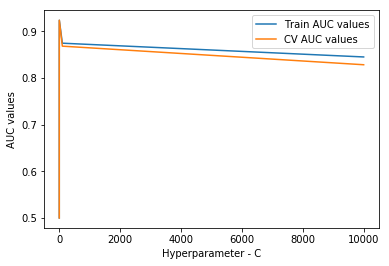

In [321]:
#plotting ROC curve for train and CV data
plt.plot(hyperparameters['C'],AUC_bow_train,label='Train AUC values')
plt.plot(hyperparameters['C'],AUC_bow_CV_l1,label='CV AUC values')
plt.legend()
plt.xlabel('Hyperparameter - C')
plt.ylabel('AUC values')

Observation : Our model is performing well when tested with CV data,so we can go ahead with considering best value of C as optimal_C_bow_l1  

In [322]:
#As we have selected our best parameter,so finding auc scores for our test data to shown the results
AUC_bow_test_l1 = []
for x in hyperparameters['C']:
    model = LogisticRegression(penalty='l1',C=x)
    model.fit(final_counts,y_train2)
    y_pred = model.predict_proba(final_countsTEST)[:,1]
    AUC_bow_test_l1.append(metrics.roc_auc_score(y_test,y_pred))

Text(0,0.5,'AUC values')

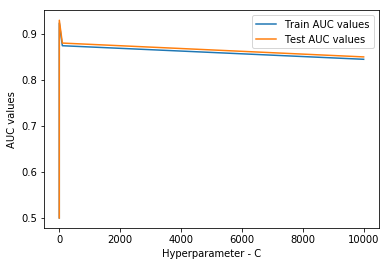

In [323]:
#plotting ROC curve for train and test data
plt.plot(hyperparameters['C'],AUC_bow_train,label='Train AUC values')
plt.plot(hyperparameters['C'],AUC_bow_test_l1,label='Test AUC values')
plt.legend()
plt.xlabel('Hyperparameter - C')
plt.ylabel('AUC values')

[8.216660833041653, 9.108253358925143, 9.60918614020951, 9.858556701030928, 9.953410981697171, 9.583601286173634, 9.008361839604714, 7.54380272550292, 5.251661918328585, 0.20766831773986424]
0.5


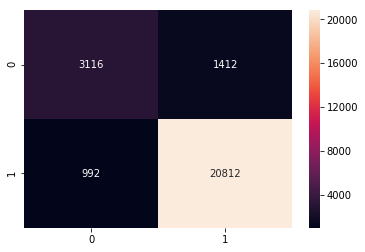

In [324]:
from sklearn.preprocessing import binarize
final_model_bow_l1 = LogisticRegression(penalty='l1',C=optimal_C_bow_l1)
final_model_bow_l1.fit(final_counts,y_train2)
y_pred_bow_l1 = final_model_bow_l1.predict_proba(final_countsTEST)[:,1]

#finding the optimal threshold (based on correct prediction vs false prediction ration) for confusion matrix for a class to be classified
t = list(np.arange(0.1,1.1,0.1))
ratio=[]
for x in t:
    pred_class = binarize(y_pred_bow_l1.reshape(-1,1),threshold = x)
    tn, fp, fn, tp = metrics.confusion_matrix(y_test,pred_class).ravel()
    ratio.append((tp+tn)/(fp+fn))
print(ratio)
optimal_t = t[ratio.index(max(ratio))]
print(optimal_t)

##plotting confusion matrix for optimal threshold value

pred_class = binarize(y_pred_bow_l1.reshape(-1,1),threshold = optimal_t)
cm2 = metrics.confusion_matrix(y_test,pred_class)
plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm2,annot=True,ax=ax2,fmt='g')


#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [325]:
# Please write all the code with proper documentation
#using already trained model

coef_bow_l1 = final_model_bow_l1.coef_.ravel()
sparsity_bow_l1 = np.mean(coef_bow_l1 == 0) * 100

print(sparsity_bow_l1)
print(np.count_nonzero(final_model_bow_l1.coef_))

90.73062654575432
3598


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

AUC score for Logistic Regression Model with L2 regularization  [0.67665382 0.92163524 0.92344539 0.88584036 0.87624526]
best_auc_score_bow_l2  0.9234453932850831
optimal_C_bow_l2  1


Text(0,0.5,'AUC values')

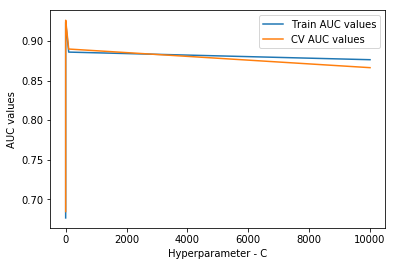

In [326]:
# Please write all the code with proper documentation

hyperparameters = {'C':[10**-4,10**-2,10**0,10**2,10**4]}
model = LogisticRegression(penalty='l2')

clf_LR_l2 = RandomizedSearchCV(model,param_distributions=hyperparameters,scoring='roc_auc',cv=10,random_state=100)
clf_LR_l2.fit(final_counts,y_train2)

print('AUC score for Logistic Regression Model with L2 regularization ',clf_LR_l2.cv_results_['mean_test_score'])

AUC_bow_train_l2 = clf_LR_l2.cv_results_['mean_test_score']
best_auc_score_bow_l2 = clf_LR_l2.best_score_
optimal_C_bow_l2 = clf_LR_l2.best_params_['C']

print('best_auc_score_bow_l2 ',best_auc_score_bow_l2)
print('optimal_C_bow_l2 ',optimal_C_bow_l2)

#finding auc scores for our CV data for validation
AUC_bow_CV_l2 = []
for x in hyperparameters['C']:
    model = LogisticRegression(penalty='l2',C=x)
    model.fit(final_counts,y_train2)
    y_pred = model.predict_proba(final_countsCV)[:,1]
    AUC_bow_CV_l2.append(metrics.roc_auc_score(y_CV,y_pred))
    

#plotting ROC curve for train and CV data
plt.plot(hyperparameters['C'],AUC_bow_train_l2,label='Train AUC values')
plt.plot(hyperparameters['C'],AUC_bow_CV_l2,label='CV AUC values')
plt.legend()
plt.xlabel('Hyperparameter - C')
plt.ylabel('AUC values')

#Observation : Our model is performing well when tested with CV data,so we can go ahead with considering best value of C as optimal_C_bow_l1  



Text(0,0.5,'AUC values')

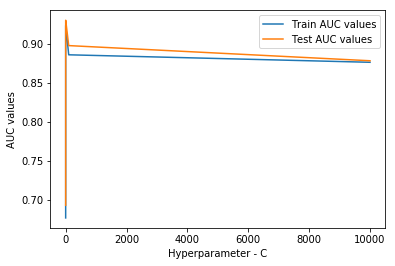

In [327]:
#As we have selected our best parameter,so finding auc scores for our test data to shown the results
AUC_bow_test_l2 = []
for x in hyperparameters['C']:
    model = LogisticRegression(penalty='l2',C=x)
    model.fit(final_counts,y_train2)
    y_pred = model.predict_proba(final_countsTEST)[:,1]
    AUC_bow_test_l2.append(metrics.roc_auc_score(y_test,y_pred))

#plotting ROC curve for train and test data
plt.plot(hyperparameters['C'],AUC_bow_train_l2,label='Train AUC values')
plt.plot(hyperparameters['C'],AUC_bow_test_l2,label='Test AUC values')
plt.legend()
plt.xlabel('Hyperparameter - C')
plt.ylabel('AUC values')

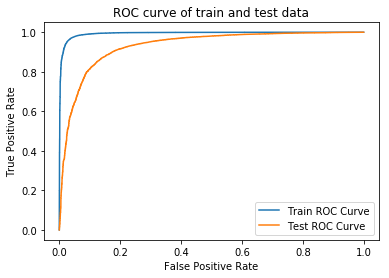

In [328]:
model_l2 = LogisticRegression(penalty='l2',C=optimal_C_bow_l2)
model_l2 = model_l2.fit(final_counts,y_train2)

y_pred_l2 = model_l2.predict_proba(final_counts)[:,1]
fpr,tpr,t = metrics.roc_curve(y_train2,y_pred_l2)

y_pred_l22 = model_l2.predict_proba(final_countsTEST)[:,1]
fpr2,tpr2,t = metrics.roc_curve(y_test,y_pred_l22)

plt.plot(fpr,tpr,label='Train ROC Curve')
plt.plot(fpr2,tpr2,label='Test ROC Curve')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of train and test data')
plt.show()

optimal_threshold based on ratio  0.4


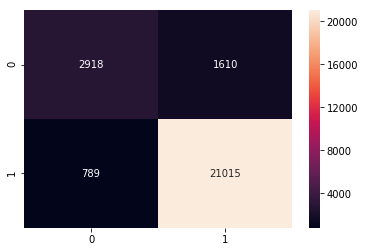

In [329]:
from sklearn.preprocessing import binarize
final_model_bow_l2 = LogisticRegression(penalty='l2',C=optimal_C_bow_l2)
final_model_bow_l2.fit(final_counts,y_train2)
y_pred_bow_l2 = final_model_bow_l2.predict_proba(final_countsTEST)[:,1]

#finding the optimal threshold (based on correct prediction vs false prediction ration) for confusion matrix for a class to be classified
t = list(np.arange(0.1,1.1,0.1))
ratio=[]
for x in t:
    pred_class = binarize(y_pred_bow_l2.reshape(-1,1),threshold = x)
    tn, fp, fn, tp = metrics.confusion_matrix(y_test,pred_class).ravel()
    ratio.append((tp+tn)/(fp+fn))
#print(ratio)
optimal_t = t[ratio.index(max(ratio))]
print('optimal_threshold based on ratio ',optimal_t)

##plotting confusion matrix for optimal threshold value

pred_class = binarize(y_pred_bow_l2.reshape(-1,1),threshold = optimal_t)
cm2 = metrics.confusion_matrix(y_test,pred_class)
plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm2,annot=True,ax=ax2,fmt='g')


In [330]:
#Calculating sparsity on weight vector obtained using L2 regularization on BOW
#using already trained model

coef_bow_l2 = final_model_bow_l2.coef_.ravel()
sparsity_bow_l2 = np.mean(coef_bow_l2 == 0) * 100

print('sparsity_bow_l2 ',sparsity_bow_l2)
print('Number of non zero entries which indicates sparsity ',np.count_nonzero(final_model_bow_l2.coef_))

sparsity_bow_l2  0.0
Number of non zero entries which indicates sparsity  38816


OBSERVATION : We see that using l2 penalty the sparsity gets reduced dramatically as compared to l1

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [331]:
# Please write all the code with proper documentation
coef_before_l2 = final_model_bow_l2.coef_

#generating and adding small noise to the data and calculating weights again

e = np.random.normal(loc=0,scale=0.00000001,size=final_counts.data.shape)
X_noisy_l2 = final_counts
X_noisy_l2.data = final_counts.data + e

print(X_noisy_l2.shape)

(43008, 38816)


In [332]:
#Introducing noisy data to our model
noisy_model_bow_l2 = LogisticRegression(penalty='l2',C=optimal_C_bow_l2)
noisy_model_bow_l2.fit(X_noisy_l2,y_train2)

#getting new weights

coef_after_l2 = noisy_model_bow_l2.coef_

In [333]:
#to eliminate divisible by zero error,adding 10^-6 to coef_before_l2 and coef_after_l2
coef_before_l2 += 10**-6
coef_after_l2 += 10**-6
change_vec_l2 = []

#Calculating the percentage change in weights
for i in range(coef_before_l2.shape[1]):
    w = ((coef_after_l2[0][i] - coef_before_l2[0][i])/(coef_before_l2[0][i]))
    change_vec_l2.append(w)
    

In [334]:
#Sorting to get the quantiles
change_vec_l2_ = sorted(change_vec_l2,reverse=True)

for i in range(11):
    print(str(i*10) + 'th percentile value is ' + str(np.quantile(change_vec_l2_,i*0.1)))

0th percentile value is -60.95832798190677
10th percentile value is -0.00116284257268003
20th percentile value is -0.00039880318750643804
30th percentile value is -0.00011792056077687026
40th percentile value is 2.5234760015563168e-05
50th percentile value is 0.0001627127219842885
60th percentile value is 0.0003594956564699062
70th percentile value is 0.0009741426904649556
80th percentile value is 0.0032688875999550403
90th percentile value is 0.017908821376695125
100th percentile value is 486.96216863693326


In [335]:
for i in range(90,101):
    print(str(i)+'th percentile = '+str(np.percentile(change_vec_l2_,i)))

90th percentile = 0.017908821376695125
91th percentile = 0.02255474875741044
92th percentile = 0.02921333265944996
93th percentile = 0.037462697384435285
94th percentile = 0.05575164313538149
95th percentile = 0.08022203622997413
96th percentile = 0.12018332120176677
97th percentile = 0.17162355855219702
98th percentile = 0.2697450392020361
99th percentile = 0.4753689977729935
100th percentile = 486.96216863693326


In [336]:
for i in np.linspace(99,100,11):
    print(str(i)+'th percentile = '+str(np.percentile(change_vec_l2_,i)))

99.0th percentile = 0.4753689977729935
99.1th percentile = 0.5409121618345993
99.2th percentile = 0.5636646248733802
99.3th percentile = 0.6217798731658961
99.4th percentile = 0.7455986796019688
99.5th percentile = 0.9230946327571891
99.6th percentile = 1.0511998376369933
99.7th percentile = 1.6904915318395641
99.8th percentile = 2.9532765205264875
99.9th percentile = 14.718577572829943
100.0th percentile = 486.96216863693326


In [337]:
for i in np.linspace(99.9,100,11):
    print(str(i)+'th percentile = '+str(np.percentile(change_vec_l2_,i)))

99.9th percentile = 14.718577572829943
99.91000000000001th percentile = 14.782030372458044
99.92th percentile = 17.173600121391438
99.93th percentile = 17.286817582050617
99.94th percentile = 17.286818007954743
99.95th percentile = 18.947238405769514
99.96000000000001th percentile = 25.21533605676641
99.97th percentile = 34.345398677290746
99.98th percentile = 38.09712656303578
99.99th percentile = 486.9621413614484
100.0th percentile = 486.96216863693326


In [338]:
change_vec_l2 = np.absolute(change_vec_l2).tolist()
change_vec_l2_ = np.absolute(change_vec_l2_)
j=[]
for i in np.linspace(99.9,100,11):
    print(i)
    j.append(np.percentile(change_vec_l2_,i))
    #j = change_vec_l2.index(np.percentile(change_vec_l2_,i))
    #print(j)
    #print(features_bow[j])

99.9
99.91000000000001
99.92
99.93
99.94
99.95
99.96000000000001
99.97
99.98
99.99
100.0


In [339]:
#finding the features whose difference is more than 2.5
j=[i for i in change_vec_l2 if i > 2.5]

for k in j:
    print(features_bow[change_vec_l2.index(k)])

admiration
adoptions
agreedthat
allergyand
alomost
althos
ammount
availabily
avidly
bamilton
beggars
beteer
beverly
bloodlines
brewingi
calnat
changeno
checkpoints
checkwith
choicest
chonditrin
cobble
compounding
concerened
conclusionbuy
confirming
consecutively
contour
contraire
cortisone
courts
culinaryteas
defecating
denosyl
depiicts
differenthypoallergenic
dillon
diningroom
distracters
dizzying
doce
doingbetter
drizzling
dumas
enlarges
enrobing
epidemiological
ess
facimilies
fads
favortires
fiends
fileted
flares
flavorspomegranates
floured
fontina
formulain
formulamy
forture
freeand
furlessness
goad
granatus
happyland
hassels
headlines
hepatitis
hiv
hubbie
hustle
hustling
hutchinson
hv
icre
imperilled
implode
inadequte
inferiors
inherit
insuring
isold
iteration
kitcen
knfe
lifestle
lubricate
lubricating
lubrication
magnificient
marscapone
maverick
medicate
microbrew
miffed
mindell
moistening
mongut
narrowly
nescaf
notdamaged
npr
ouncegoats
oversees
particulari
periferal
personalcar

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [340]:
# Please write all the code with proper documentation
#finding the index of positive features

i_pos = np.argsort(coef_before_l2)[:,::-1]

for i in i_pos[0][0:10]:
    print(features_bow[i])

delicious
holds
beat
excellent
pleasantly
yummy
perfect
pleased
amazing
addictive


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [341]:
# Please write all the code with proper documentation
i_neg = np.argsort(coef_before_l2)

for i in i_neg[0][0:10]:
    print(features_bow[i])


worst
tasteless
disappointing
terrible
cancelled
canceled
disappointment
died
awful
sounded


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

AUC score for Logistic Regression Model with TFIDF features and l1 regularization  [0.5        0.6642516  0.9479565  0.93388236 0.92023391]
best_auc_score_tfidf_l1  0.9479564980759493
optimal_C_tfidf_l1  1


Text(0,0.5,'AUC values')

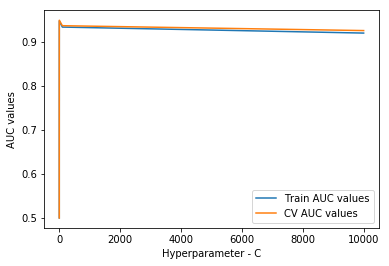

In [342]:
# Please write all the code with proper documentation

hyperparameters = {'C':[10**-4,10**-2,10**0,10**2,10**4]}
model = LogisticRegression(penalty='l1')

clf_tfidf_l1 = RandomizedSearchCV(model,param_distributions=hyperparameters,scoring='roc_auc',cv=10,random_state=100)
clf_tfidf_l1.fit(final_tf_idf,y_train2)

print('AUC score for Logistic Regression Model with TFIDF features and l1 regularization ',clf_tfidf_l1.cv_results_['mean_test_score'])

AUC_tfidf_train_l1 = clf_tfidf_l1.cv_results_['mean_test_score']
best_auc_score_tfidf_l1 = clf_tfidf_l1.best_score_
optimal_C_tfidf_l1 = clf_tfidf_l1.best_params_['C']

print('best_auc_score_tfidf_l1 ',best_auc_score_tfidf_l1)
print('optimal_C_tfidf_l1 ',optimal_C_tfidf_l1)

#finding auc scores for our CV data for validation
AUC_tfidf_CV_l1 = []
for x in hyperparameters['C']:
    model = LogisticRegression(penalty='l1',C=x)
    model.fit(final_tf_idf,y_train2)
    y_pred = model.predict_proba(final_tf_idfCV)[:,1]
    AUC_tfidf_CV_l1.append(metrics.roc_auc_score(y_CV,y_pred))
    

#plotting ROC curve for train and CV data
plt.plot(hyperparameters['C'],AUC_tfidf_train_l1,label='Train AUC values')
plt.plot(hyperparameters['C'],AUC_tfidf_CV_l1,label='CV AUC values')
plt.legend()
plt.xlabel('Hyperparameter - C')
plt.ylabel('AUC values')

#Observation : Our model is performing well when tested with CV data,so we can go ahead with considering best value of C as optimal_C_bow_l1  

Text(0,0.5,'AUC values')

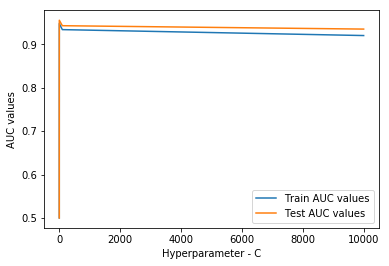

In [343]:
#As we have selected our best parameter,so finding auc scores for our test data to shown the results
AUC_tfidf_test_l1 = []
for x in hyperparameters['C']:
    model = LogisticRegression(penalty='l1',C=x)
    model.fit(final_tf_idf,y_train2)
    y_pred = model.predict_proba(final_tf_idfTEST)[:,1]
    AUC_tfidf_test_l1.append(metrics.roc_auc_score(y_test,y_pred))

#plotting ROC curve for train and test data
plt.plot(hyperparameters['C'],AUC_tfidf_train_l1,label='Train AUC values')
plt.plot(hyperparameters['C'],AUC_tfidf_test_l1,label='Test AUC values')
plt.legend()
plt.xlabel('Hyperparameter - C')
plt.ylabel('AUC values')

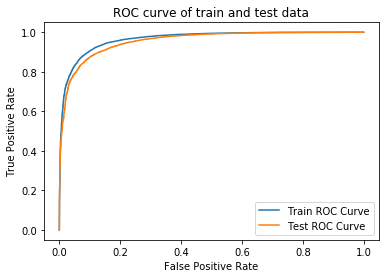

In [344]:
#Plotting ROC curve as FPR vs TPR

model_roc_l1 = LogisticRegression(penalty='l1',C=optimal_C_tfidf_l1)
model_roc_l1 = model_roc_l1.fit(final_tf_idf,y_train2)

y_pred_train_l1 = model_roc_l1.predict_proba(final_tf_idf)[:,1]
fpr,tpr,t = metrics.roc_curve(y_train2,y_pred_train_l1)

y_pred_test_l1 = model_roc_l1.predict_proba(final_tf_idfTEST)[:,1]
fpr2,tpr2,t = metrics.roc_curve(y_test,y_pred_test_l1)

plt.plot(fpr,tpr,label='Train ROC Curve')
plt.plot(fpr2,tpr2,label='Test ROC Curve')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of train and test data')
plt.show()

optimal_t_tfidf_l1  0.6


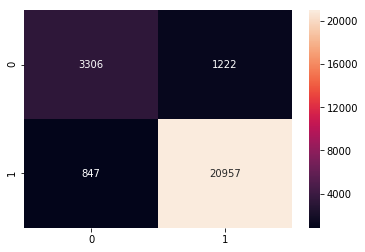

In [345]:

final_model_tfidf_l1 = LogisticRegression(penalty='l1',C=optimal_C_tfidf_l1)
final_model_tfidf_l1.fit(final_tf_idf,y_train2)
y_pred_tfidf_l1 = final_model_tfidf_l1.predict_proba(final_tf_idfTEST)[:,1]

#finding the optimal threshold (based on correct prediction vs false prediction ration) for confusion matrix for a class to be classified
t = list(np.arange(0.1,1.1,0.1))
ratio=[]
for x in t:
    pred_class = binarize(y_pred_tfidf_l1.reshape(-1,1),threshold = x)
    tn, fp, fn, tp = metrics.confusion_matrix(y_test,pred_class).ravel()
    ratio.append((tp+tn)/(fp+fn))
#print(ratio)
optimal_t_tfidf_l1 = t[ratio.index(max(ratio))]
print('optimal_t_tfidf_l1 ',optimal_t_tfidf_l1)

##plotting confusion matrix for optimal threshold value

pred_class = binarize(y_pred_tfidf_l1.reshape(-1,1),threshold = optimal_t_tfidf_l1)
cm2 = metrics.confusion_matrix(y_test,pred_class)
plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm2,annot=True,ax=ax2,fmt='g')

In [346]:
##Calculating sparsity on weight vector obtained using L1 regularization on TFIDF
#using already trained model

coef_tfidf_l1 = final_model_tfidf_l1.coef_.ravel()
sparsity_tfidf_l1 = np.mean(coef_tfidf_l1 == 0) * 100

print('sparsity_tfidf_l1 ',sparsity_tfidf_l1)
print('Number of non zero entries which indicates sparsity ',np.count_nonzero(final_model_tfidf_l1.coef_))

sparsity_tfidf_l1  95.72663316582914
Number of non zero entries which indicates sparsity  1063


### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

AUC score for Logistic Regression Model with TFIDF features and l2 regularization  [0.69916833 0.90755775 0.95297465 0.94464753 0.93754794]
best_auc_score_tfidf_l2  0.9529746488572289
optimal_C_tfidf_l2  1


Text(0,0.5,'AUC values')

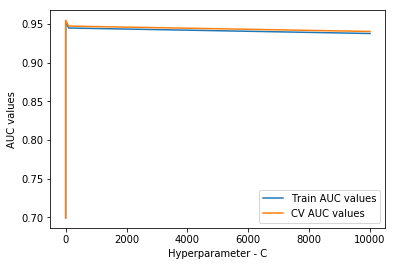

In [347]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation

hyperparameters = {'C':[10**-4,10**-2,10**0,10**2,10**4]}
model = LogisticRegression(penalty='l2')

clf_tfidf_l2 = RandomizedSearchCV(model,param_distributions=hyperparameters,scoring='roc_auc',cv=10,random_state=100)
clf_tfidf_l2.fit(final_tf_idf,y_train2)

print('AUC score for Logistic Regression Model with TFIDF features and l2 regularization ',clf_tfidf_l2.cv_results_['mean_test_score'])

AUC_tfidf_train_l2 = clf_tfidf_l2.cv_results_['mean_test_score']
best_auc_score_tfidf_l2 = clf_tfidf_l2.best_score_
optimal_C_tfidf_l2 = clf_tfidf_l2.best_params_['C']

print('best_auc_score_tfidf_l2 ',best_auc_score_tfidf_l2)
print('optimal_C_tfidf_l2 ',optimal_C_tfidf_l2)

#finding auc scores for our CV data for validation
AUC_tfidf_CV_l2 = []
for x in hyperparameters['C']:
    model = LogisticRegression(penalty='l2',C=x)
    model.fit(final_tf_idf,y_train2)
    y_pred = model.predict_proba(final_tf_idfCV)[:,1]
    AUC_tfidf_CV_l2.append(metrics.roc_auc_score(y_CV,y_pred))
    

#plotting ROC curve for train and CV data
plt.plot(hyperparameters['C'],AUC_tfidf_train_l2,label='Train AUC values')
plt.plot(hyperparameters['C'],AUC_tfidf_CV_l2,label='CV AUC values')
plt.legend()
plt.xlabel('Hyperparameter - C')
plt.ylabel('AUC values')

#Observation : Our model is performing well when tested with CV data,so we can go ahead with considering best value of C as optimal_C_bow_l1  



Text(0,0.5,'AUC values')

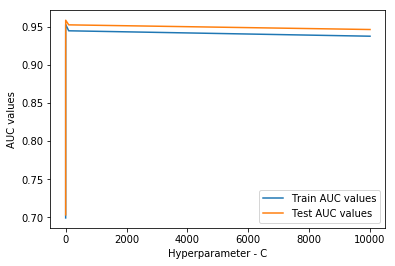

In [348]:
#As we have selected our best parameter,so finding auc scores for our test data to show the results
AUC_tfidf_test_l2 = []
for x in hyperparameters['C']:
    model = LogisticRegression(penalty='l2',C=x)
    model.fit(final_tf_idf,y_train2)
    y_pred = model.predict_proba(final_tf_idfTEST)[:,1]
    AUC_tfidf_test_l2.append(metrics.roc_auc_score(y_test,y_pred))

#plotting ROC curve for train and test data
plt.plot(hyperparameters['C'],AUC_tfidf_train_l2,label='Train AUC values')
plt.plot(hyperparameters['C'],AUC_tfidf_test_l2,label='Test AUC values')
plt.legend()
plt.xlabel('Hyperparameter - C')
plt.ylabel('AUC values')



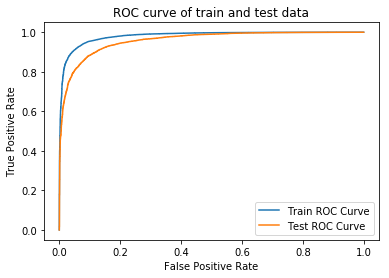

In [349]:
#Plotting ROC curve as FPR vs TPR

model_roc_l2 = LogisticRegression(penalty='l2',C=optimal_C_tfidf_l2)
model_roc_l2 = model_roc_l2.fit(final_tf_idf,y_train2)

y_pred_train_l2 = model_roc_l2.predict_proba(final_tf_idf)[:,1]
fpr,tpr,t = metrics.roc_curve(y_train2,y_pred_train_l2)

y_pred_test_l2 = model_roc_l2.predict_proba(final_tf_idfTEST)[:,1]
fpr2,tpr2,t = metrics.roc_curve(y_test,y_pred_test_l2)

plt.plot(fpr,tpr,label='Train ROC Curve')
plt.plot(fpr2,tpr2,label='Test ROC Curve')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of train and test data')
plt.show()


optimal_t_tfidf_l2  0.6


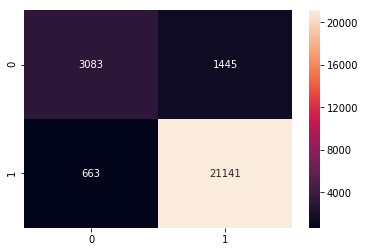

In [350]:
final_model_tfidf_l2 = LogisticRegression(penalty='l2',C=optimal_C_tfidf_l2)
final_model_tfidf_l2.fit(final_tf_idf,y_train2)
y_pred_tfidf_l2 = final_model_tfidf_l2.predict_proba(final_tf_idfTEST)[:,1]

#finding the optimal threshold (based on correct prediction vs false prediction ration) for confusion matrix for a class to be classified
t = list(np.arange(0.1,1.1,0.1))
ratio=[]
for x in t:
    pred_class = binarize(y_pred_tfidf_l2.reshape(-1,1),threshold = x)
    tn, fp, fn, tp = metrics.confusion_matrix(y_test,pred_class).ravel()
    ratio.append((tp+tn)/(fp+fn))
#print(ratio)
optimal_t_tfidf_l2 = t[ratio.index(max(ratio))]
print('optimal_t_tfidf_l2 ',optimal_t_tfidf_l2)

##plotting confusion matrix for optimal threshold value

pred_class = binarize(y_pred_tfidf_l2.reshape(-1,1),threshold = optimal_t_tfidf_l2)
cm2 = metrics.confusion_matrix(y_test,pred_class)
plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm2,annot=True,ax=ax2,fmt='g')

In [351]:
##Calculating sparsity on weight vector obtained using L1 regularization on TFIDF
#using already trained model

coef_tfidf_l2 = final_model_tfidf_l2.coef_.ravel()
sparsity_tfidf_l2 = np.mean(coef_tfidf_l2 == 0) * 100

print('sparsity_tfidf_l2 ',sparsity_tfidf_l2)
print('Number of non zero entries which indicates sparsity ',np.count_nonzero(final_model_tfidf_l2.coef_))

sparsity_tfidf_l2  0.0
Number of non zero entries which indicates sparsity  24875


### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [352]:
coef_tf = final_model_tfidf_l2.coef_
i_pos2 = np.argsort(coef_tf)[:,::-1]

for i in i_pos2[0][0:10]:
    print(features_tf_idf[i])

great
delicious
best
good
loves
love
perfect
excellent
wonderful
nice


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [353]:
# Please write all the code with proper documentation
i_neg2 = np.argsort(coef_tf)

for i in i_neg2[0][0:10]:
    print(features_tf_idf[i])

disappointed
not
worst
terrible
not good
horrible
not recommend
awful
not buy
disappointing


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

AUC score for Logistic Regression Model with Avg W2V features and l1 regularization  [0.5        0.89099636 0.89813651 0.89808568 0.89808407]
best_auc_score_avgw2v_l1  0.8981365109992843
optimal_C_avgw2v_l1  1


Text(0,0.5,'AUC values')

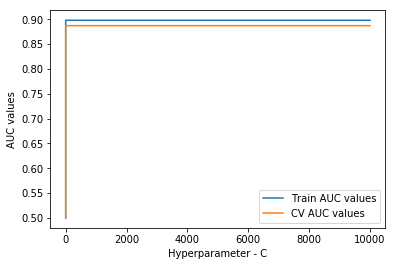

In [354]:
# Please write all the code with proper documentation


hyperparameters = {'C':[10**-4,10**-2,10**0,10**2,10**4]}
model = LogisticRegression(penalty='l1')

clf_avgw2v_l1 = RandomizedSearchCV(model,param_distributions=hyperparameters,scoring='roc_auc',cv=10,random_state=100)
clf_avgw2v_l1.fit(sent_vectors_train,y_train2)

print('AUC score for Logistic Regression Model with Avg W2V features and l1 regularization ',clf_avgw2v_l1.cv_results_['mean_test_score'])

AUC_avgw2v_train_l1 = clf_avgw2v_l1.cv_results_['mean_test_score']
best_auc_score_avgw2v_l1 = clf_avgw2v_l1.best_score_
optimal_C_avgw2v_l1 = clf_avgw2v_l1.best_params_['C']

print('best_auc_score_avgw2v_l1 ',best_auc_score_avgw2v_l1)
print('optimal_C_avgw2v_l1 ',optimal_C_avgw2v_l1)

#finding auc scores for our CV data for validation
AUC_avgw2v_CV_l1 = []
for x in hyperparameters['C']:
    model = LogisticRegression(penalty='l1',C=x)
    model.fit(sent_vectors_train,y_train2)
    y_pred = model.predict_proba(sent_vectors_cv)[:,1]
    AUC_avgw2v_CV_l1.append(metrics.roc_auc_score(y_CV,y_pred))
    

#plotting ROC curve for train and CV data
plt.plot(hyperparameters['C'],AUC_avgw2v_train_l1,label='Train AUC values')
plt.plot(hyperparameters['C'],AUC_avgw2v_CV_l1,label='CV AUC values')
plt.legend()
plt.xlabel('Hyperparameter - C')
plt.ylabel('AUC values')

#Observation : Our model is performing well when tested with CV data,so we can go ahead with considering best value of C as optimal_C_bow_l1  

Text(0,0.5,'AUC values')

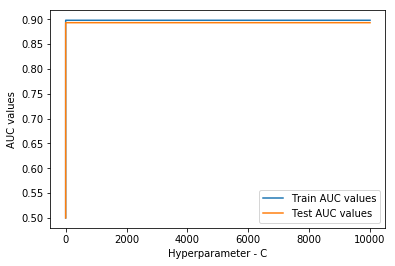

In [355]:
#As we have selected our best parameter,so finding auc scores for our test data to shown the results
AUC_avgw2v_test_l1 = []
for x in hyperparameters['C']:
    model = LogisticRegression(penalty='l1',C=x)
    model.fit(sent_vectors_train,y_train2)
    y_pred = model.predict_proba(sent_vectors_test)[:,1]
    AUC_avgw2v_test_l1.append(metrics.roc_auc_score(y_test,y_pred))

#plotting ROC curve for train and test data
plt.plot(hyperparameters['C'],AUC_avgw2v_train_l1,label='Train AUC values')
plt.plot(hyperparameters['C'],AUC_avgw2v_test_l1,label='Test AUC values')
plt.legend()
plt.xlabel('Hyperparameter - C')
plt.ylabel('AUC values')

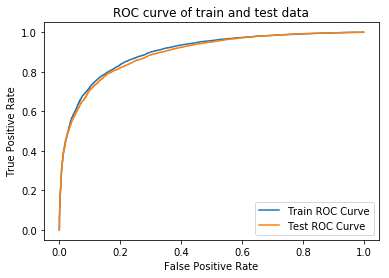

In [356]:
#Plotting ROC curve as FPR vs TPR

model_roc_l1 = LogisticRegression(penalty='l1',C=optimal_C_avgw2v_l1)
model_roc_l1 = model_roc_l1.fit(sent_vectors_train,y_train2)

y_pred_train_l1 = model_roc_l1.predict_proba(sent_vectors_train)[:,1]
fpr,tpr,t = metrics.roc_curve(y_train2,y_pred_train_l1)

y_pred_test_l1 = model_roc_l1.predict_proba(sent_vectors_test)[:,1]
fpr2,tpr2,t = metrics.roc_curve(y_test,y_pred_test_l1)

plt.plot(fpr,tpr,label='Train ROC Curve')
plt.plot(fpr2,tpr2,label='Test ROC Curve')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of train and test data')
plt.show()

optimal_t_avgw2v_l1  0.5


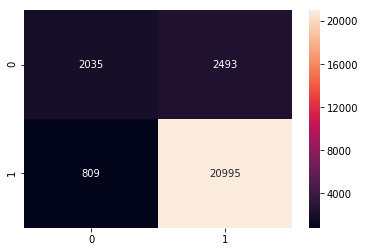

In [357]:

final_model_avgw2v_l1 = LogisticRegression(penalty='l1',C=optimal_C_avgw2v_l1)
final_model_avgw2v_l1.fit(sent_vectors_train,y_train2)
y_pred_avgw2v_l1 = final_model_avgw2v_l1.predict_proba(sent_vectors_test)[:,1]

#finding the optimal threshold (based on correct prediction vs false prediction ration) for confusion matrix for a class to be classified
t = list(np.arange(0.1,1.1,0.1))
ratio=[]
for x in t:
    pred_class = binarize(y_pred_avgw2v_l1.reshape(-1,1),threshold = x)
    tn, fp, fn, tp = metrics.confusion_matrix(y_test,pred_class).ravel()
    ratio.append((tp+tn)/(fp+fn))
#print(ratio)
optimal_t_avgw2v_l1 = t[ratio.index(max(ratio))]
print('optimal_t_avgw2v_l1 ',optimal_t_avgw2v_l1)

##plotting confusion matrix for optimal threshold value

pred_class = binarize(y_pred_avgw2v_l1.reshape(-1,1),threshold = optimal_t_avgw2v_l1)
cm2 = metrics.confusion_matrix(y_test,pred_class)
plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm2,annot=True,ax=ax2,fmt='g')


In [358]:
##Calculating sparsity on weight vector obtained using L1 regularization on AVG W2V
#using already trained model

coef_avgw2v_l1 = final_model_avgw2v_l1.coef_.ravel()
sparsity_avgw2v_l1 = np.mean(coef_avgw2v_l1 == 0) * 100

print('sparsity_avgw2v_l1 ',sparsity_avgw2v_l1)
print('Number of non zero entries which indicates sparsity ',np.count_nonzero(final_model_avgw2v_l1.coef_))

sparsity_avgw2v_l1  2.0
Number of non zero entries which indicates sparsity  49


### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

AUC score for Logistic Regression Model with Avg W2V features and l2 regularization  [0.8114141  0.89619228 0.89812146 0.89809045 0.89809053]
best_auc_score_avgw2v_l1  0.8981214573355768
optimal_C_avgw2v_l1  1


Text(0,0.5,'AUC values')

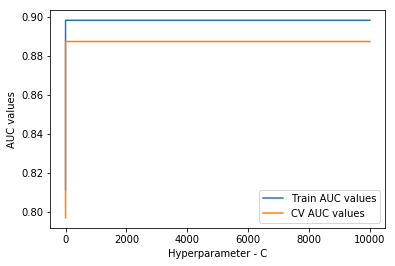

In [359]:
# Please write all the code with proper documentation

hyperparameters = {'C':[10**-4,10**-2,10**0,10**2,10**4]}
model = LogisticRegression(penalty='l2')

clf_avgw2v_l2 = RandomizedSearchCV(model,param_distributions=hyperparameters,scoring='roc_auc',cv=10,random_state=100)
clf_avgw2v_l2.fit(sent_vectors_train,y_train2)

print('AUC score for Logistic Regression Model with Avg W2V features and l2 regularization ',clf_avgw2v_l2.cv_results_['mean_test_score'])

AUC_avgw2v_train_l2 = clf_avgw2v_l2.cv_results_['mean_test_score']
best_auc_score_avgw2v_l2 = clf_avgw2v_l2.best_score_
optimal_C_avgw2v_l2 = clf_avgw2v_l2.best_params_['C']

print('best_auc_score_avgw2v_l1 ',best_auc_score_avgw2v_l2)
print('optimal_C_avgw2v_l1 ',optimal_C_avgw2v_l2)

#finding auc scores for our CV data for validation
AUC_avgw2v_CV_l2 = []
for x in hyperparameters['C']:
    model = LogisticRegression(penalty='l2',C=x)
    model.fit(sent_vectors_train,y_train2)
    y_pred = model.predict_proba(sent_vectors_cv)[:,1]
    AUC_avgw2v_CV_l2.append(metrics.roc_auc_score(y_CV,y_pred))
    

#plotting ROC curve for train and CV data
plt.plot(hyperparameters['C'],AUC_avgw2v_train_l2,label='Train AUC values')
plt.plot(hyperparameters['C'],AUC_avgw2v_CV_l2,label='CV AUC values')
plt.legend()
plt.xlabel('Hyperparameter - C')
plt.ylabel('AUC values')

#Observation : Our model is performing well when tested with CV data,so we can go ahead with considering best value of C as optimal_C_bow_l1  

Text(0,0.5,'AUC values')

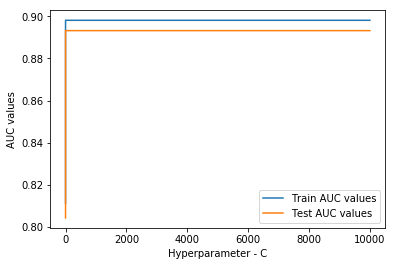

In [360]:
#As we have selected our best parameter,so finding auc scores for our test data to shown the results
AUC_avgw2v_test_l2 = []
for x in hyperparameters['C']:
    model = LogisticRegression(penalty='l2',C=x)
    model.fit(sent_vectors_train,y_train2)
    y_pred = model.predict_proba(sent_vectors_test)[:,1]
    AUC_avgw2v_test_l2.append(metrics.roc_auc_score(y_test,y_pred))

#plotting ROC curve for train and test data
plt.plot(hyperparameters['C'],AUC_avgw2v_train_l2,label='Train AUC values')
plt.plot(hyperparameters['C'],AUC_avgw2v_test_l2,label='Test AUC values')
plt.legend()
plt.xlabel('Hyperparameter - C')
plt.ylabel('AUC values')



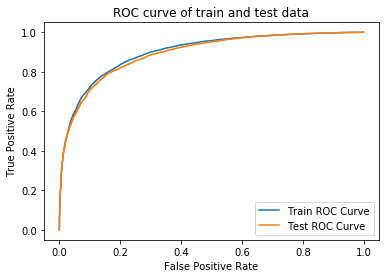

In [361]:
#Plotting ROC curve as FPR vs TPR

model_roc_l2 = LogisticRegression(penalty='l2',C=optimal_C_avgw2v_l2)
model_roc_l2 = model_roc_l2.fit(sent_vectors_train,y_train2)

y_pred_train_l2 = model_roc_l2.predict_proba(sent_vectors_train)[:,1]
fpr,tpr,t = metrics.roc_curve(y_train2,y_pred_train_l2)

y_pred_test_l2 = model_roc_l2.predict_proba(sent_vectors_test)[:,1]
fpr2,tpr2,t = metrics.roc_curve(y_test,y_pred_test_l2)

plt.plot(fpr,tpr,label='Train ROC Curve')
plt.plot(fpr2,tpr2,label='Test ROC Curve')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of train and test data')
plt.show()



optimal_t_avgw2v_l2  0.5


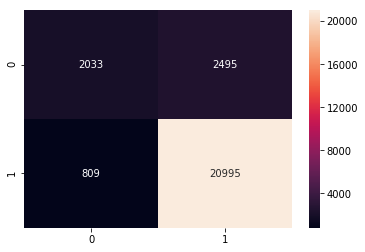

In [362]:
#building a final model with optimal C so as to generate a onfusion matrix 
final_model_avgw2v_l2 = LogisticRegression(penalty='l2',C=optimal_C_avgw2v_l2)
final_model_avgw2v_l2.fit(sent_vectors_train,y_train2)
y_pred_avgw2v_l2 = final_model_avgw2v_l2.predict_proba(sent_vectors_test)[:,1]

#finding the optimal threshold (based on correct prediction vs false prediction ration) for confusion matrix for a class to be classified
t = list(np.arange(0.1,1.1,0.1))
ratio=[]
for x in t:
    pred_class = binarize(y_pred_avgw2v_l2.reshape(-1,1),threshold = x)
    tn, fp, fn, tp = metrics.confusion_matrix(y_test,pred_class).ravel()
    ratio.append((tp+tn)/(fp+fn))
#print(ratio)
optimal_t_avgw2v_l2 = t[ratio.index(max(ratio))]
print('optimal_t_avgw2v_l2 ',optimal_t_avgw2v_l2)

##plotting confusion matrix for optimal threshold value

pred_class = binarize(y_pred_avgw2v_l2.reshape(-1,1),threshold = optimal_t_avgw2v_l2)
cm2 = metrics.confusion_matrix(y_test,pred_class)
plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm2,annot=True,ax=ax2,fmt='g')

In [363]:
##Calculating sparsity on weight vector obtained using L1 regularization on AVG W2V
#using already trained model

coef_avgw2v_l2 = final_model_avgw2v_l2.coef_.ravel()
sparsity_avgw2v_l2 = np.mean(coef_avgw2v_l2 == 0) * 100

print('sparsity_avgw2v_l2 ',sparsity_avgw2v_l2)
print('Number of non zero entries which indicates sparsity ',np.count_nonzero(final_model_avgw2v_l2.coef_))

sparsity_avgw2v_l2  0.0
Number of non zero entries which indicates sparsity  50


## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

AUC score for Logistic Regression Model with TFIDF W2V features and l1 regularization  [0.5        0.86429901 0.87372879 0.87369363 0.87368791]
best_auc_score_tfidfw2v_l1  0.8737287909806475
optimal_C_tfidfw2v_l1  1


Text(0,0.5,'AUC values')

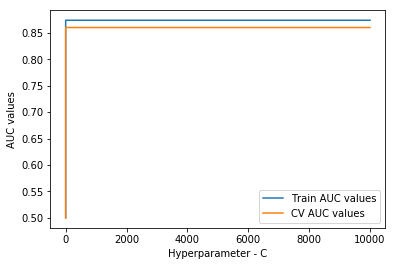

In [364]:
# Please write all the code with proper documentation

hyperparameters = {'C':[10**-4,10**-2,10**0,10**2,10**4]}
model = LogisticRegression(penalty='l1')

clf_tfidfw2v_l1 = RandomizedSearchCV(model,param_distributions=hyperparameters,scoring='roc_auc',cv=10,random_state=100)
clf_tfidfw2v_l1.fit(tfidf_sent_vectors_train,y_train2)

print('AUC score for Logistic Regression Model with TFIDF W2V features and l1 regularization ',clf_tfidfw2v_l1.cv_results_['mean_test_score'])

AUC_tfidfw2v_train_l1 = clf_tfidfw2v_l1.cv_results_['mean_test_score']
best_auc_score_tfidfw2v_l1 = clf_tfidfw2v_l1.best_score_
optimal_C_tfidfw2v_l1 = clf_tfidfw2v_l1.best_params_['C']

print('best_auc_score_tfidfw2v_l1 ',best_auc_score_tfidfw2v_l1)
print('optimal_C_tfidfw2v_l1 ',optimal_C_tfidfw2v_l1)

#finding auc scores for our CV data for validation
AUC_tfidfw2v_CV_l1 = []
for x in hyperparameters['C']:
    model = LogisticRegression(penalty='l1',C=x)
    model.fit(tfidf_sent_vectors_train,y_train2)
    y_pred = model.predict_proba(tfidf_sent_vectors_CV)[:,1]
    AUC_tfidfw2v_CV_l1.append(metrics.roc_auc_score(y_CV,y_pred))
    

#plotting ROC curve for train and CV data
plt.plot(hyperparameters['C'],AUC_tfidfw2v_train_l1,label='Train AUC values')
plt.plot(hyperparameters['C'],AUC_tfidfw2v_CV_l1,label='CV AUC values')
plt.legend()
plt.xlabel('Hyperparameter - C')
plt.ylabel('AUC values')

#Observation : Our model is performing well when tested with CV data,so we can go ahead with considering best value of C as optimal_C_bow_l1  



Text(0,0.5,'AUC values')

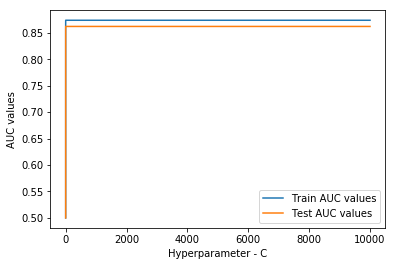

In [365]:
#As we have selected our best parameter,so finding auc scores for our test data to shown the results
AUC_tfidfw2v_test_l1 = []
for x in hyperparameters['C']:
    model = LogisticRegression(penalty='l1',C=x)
    model.fit(tfidf_sent_vectors_train,y_train2)
    y_pred = model.predict_proba(tfidf_sent_vectors_test)[:,1]
    AUC_tfidfw2v_test_l1.append(metrics.roc_auc_score(y_test,y_pred))

#plotting ROC curve for train and test data
plt.plot(hyperparameters['C'],AUC_tfidfw2v_train_l1,label='Train AUC values')
plt.plot(hyperparameters['C'],AUC_tfidfw2v_test_l1,label='Test AUC values')
plt.legend()
plt.xlabel('Hyperparameter - C')
plt.ylabel('AUC values')



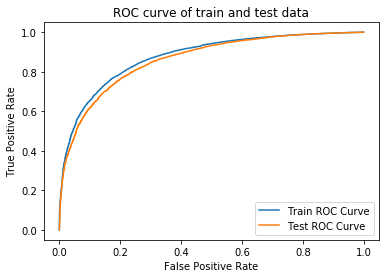

In [366]:
#Plotting ROC curve as FPR vs TPR

model_roc_l1 = LogisticRegression(penalty='l1',C=optimal_C_tfidfw2v_l1)
model_roc_l1 = model_roc_l1.fit(tfidf_sent_vectors_train,y_train2)

y_pred_train_l1 = model_roc_l1.predict_proba(tfidf_sent_vectors_train)[:,1]
fpr,tpr,t = metrics.roc_curve(y_train2,y_pred_train_l1)

y_pred_test_l1 = model_roc_l1.predict_proba(tfidf_sent_vectors_test)[:,1]
fpr2,tpr2,t = metrics.roc_curve(y_test,y_pred_test_l1)

plt.plot(fpr,tpr,label='Train ROC Curve')
plt.plot(fpr2,tpr2,label='Test ROC Curve')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of train and test data')
plt.show()

optimal_t_tfidfw2v_l1  0.5


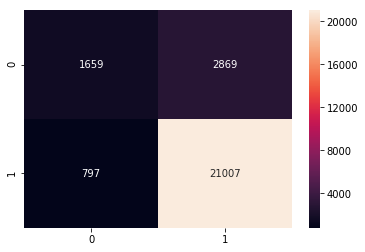

In [367]:
final_model_tfidfw2v_l1 = LogisticRegression(penalty='l1',C=optimal_C_tfidfw2v_l1)
final_model_tfidfw2v_l1.fit(tfidf_sent_vectors_train,y_train2)
y_pred_tfidfw2v_l1 = final_model_tfidfw2v_l1.predict_proba(tfidf_sent_vectors_test)[:,1]

#finding the optimal threshold (based on correct prediction vs false prediction ration) for confusion matrix for a class to be classified
t = list(np.arange(0.1,1.1,0.1))
ratio=[]
for x in t:
    pred_class = binarize(y_pred_tfidfw2v_l1.reshape(-1,1),threshold = x)
    tn, fp, fn, tp = metrics.confusion_matrix(y_test,pred_class).ravel()
    ratio.append((tp+tn)/(fp+fn))
#print(ratio)
optimal_t_tfidfw2v_l1 = t[ratio.index(max(ratio))]
print('optimal_t_tfidfw2v_l1 ',optimal_t_tfidfw2v_l1)

##plotting confusion matrix for optimal threshold value

pred_class = binarize(y_pred_tfidfw2v_l1.reshape(-1,1),threshold = optimal_t_tfidfw2v_l1)
cm2 = metrics.confusion_matrix(y_test,pred_class)
plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm2,annot=True,ax=ax2,fmt='g')

In [368]:

##Calculating sparsity on weight vector obtained using L1 regularization on AVG W2V
#using already trained model

coef_tfidfw2v_l1 = final_model_tfidfw2v_l1.coef_.ravel()
sparsity_tfidf2v_l1 = np.mean(coef_tfidfw2v_l1 == 0) * 100

print('sparsity_tfidf2v_l1 ',sparsity_tfidf2v_l1)
print('Number of non zero entries which indicates sparsity ',np.count_nonzero(final_model_tfidfw2v_l1.coef_))

sparsity_tfidf2v_l1  2.0
Number of non zero entries which indicates sparsity  49


### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

AUC score for Logistic Regression Model with TFIDF W2V features and l2 regularization  [0.77597419 0.87083341 0.87371027 0.87369338 0.87369289]
best_auc_score_tfidfw2v_l2  0.873710271620191
optimal_C_tfidfw2v_l2  1


Text(0,0.5,'AUC values')

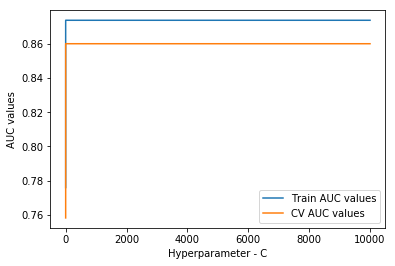

In [369]:
# Please write all the code with proper documentation

hyperparameters = {'C':[10**-4,10**-2,10**0,10**2,10**4]}
model = LogisticRegression(penalty='l2')

clf_tfidfw2v_l2 = RandomizedSearchCV(model,param_distributions=hyperparameters,scoring='roc_auc',cv=10,random_state=100)
clf_tfidfw2v_l2.fit(tfidf_sent_vectors_train,y_train2)

print('AUC score for Logistic Regression Model with TFIDF W2V features and l2 regularization ',clf_tfidfw2v_l2.cv_results_['mean_test_score'])

AUC_tfidfw2v_train_l2 = clf_tfidfw2v_l2.cv_results_['mean_test_score']
best_auc_score_tfidfw2v_l2 = clf_tfidfw2v_l2.best_score_
optimal_C_tfidfw2v_l2 = clf_tfidfw2v_l2.best_params_['C']

print('best_auc_score_tfidfw2v_l2 ',best_auc_score_tfidfw2v_l2)
print('optimal_C_tfidfw2v_l2 ',optimal_C_tfidfw2v_l2)

#finding auc scores for our CV data for validation
AUC_tfidfw2v_CV_l2 = []
for x in hyperparameters['C']:
    model = LogisticRegression(penalty='l2',C=x)
    model.fit(tfidf_sent_vectors_train,y_train2)
    y_pred = model.predict_proba(tfidf_sent_vectors_CV)[:,1]
    AUC_tfidfw2v_CV_l2.append(metrics.roc_auc_score(y_CV,y_pred))
    

#plotting ROC curve for train and CV data
plt.plot(hyperparameters['C'],AUC_tfidfw2v_train_l2,label='Train AUC values')
plt.plot(hyperparameters['C'],AUC_tfidfw2v_CV_l2,label='CV AUC values')
plt.legend()
plt.xlabel('Hyperparameter - C')
plt.ylabel('AUC values')

#Observation : Our model is performing well when tested with CV data,so we can go ahead with considering best value of C as optimal_C_bow_l2  


Text(0,0.5,'AUC values')

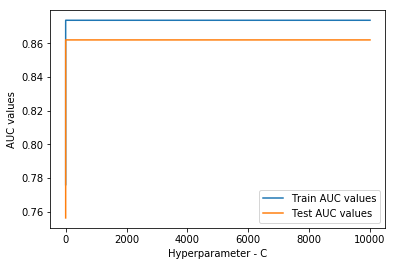

In [370]:

#As we have selected our best parameter,so finding auc scores for our test data to shown the results
AUC_tfidfw2v_test_l2 = []
for x in hyperparameters['C']:
    model = LogisticRegression(penalty='l2',C=x)
    model.fit(tfidf_sent_vectors_train,y_train2)
    y_pred = model.predict_proba(tfidf_sent_vectors_test)[:,1]
    AUC_tfidfw2v_test_l2.append(metrics.roc_auc_score(y_test,y_pred))

#plotting ROC curve for train and test data
plt.plot(hyperparameters['C'],AUC_tfidfw2v_train_l2,label='Train AUC values')
plt.plot(hyperparameters['C'],AUC_tfidfw2v_test_l2,label='Test AUC values')
plt.legend()
plt.xlabel('Hyperparameter - C')
plt.ylabel('AUC values')





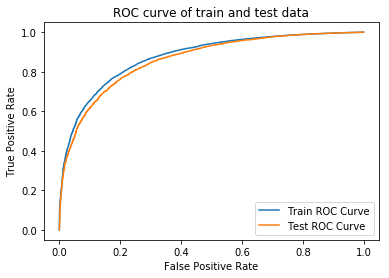

In [371]:
#Plotting ROC curve as FPR vs TPR

model_roc_l2 = LogisticRegression(penalty='l2',C=optimal_C_tfidfw2v_l2)
model_roc_l2 = model_roc_l2.fit(tfidf_sent_vectors_train,y_train2)

y_pred_train_l2 = model_roc_l2.predict_proba(tfidf_sent_vectors_train)[:,1]
fpr,tpr,t = metrics.roc_curve(y_train2,y_pred_train_l2)

y_pred_test_l2 = model_roc_l2.predict_proba(tfidf_sent_vectors_test)[:,1]
fpr2,tpr2,t = metrics.roc_curve(y_test,y_pred_test_l2)

plt.plot(fpr,tpr,label='Train ROC Curve')
plt.plot(fpr2,tpr2,label='Test ROC Curve')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of train and test data')
plt.show()



optimal_t_tfidfw2v_l2  0.5


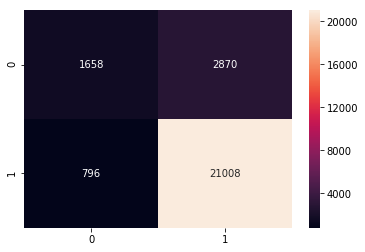

In [372]:
final_model_tfidfw2v_l2 = LogisticRegression(penalty='l2',C=optimal_C_tfidfw2v_l2)
final_model_tfidfw2v_l2.fit(tfidf_sent_vectors_train,y_train2)
y_pred_tfidfw2v_l2 = final_model_tfidfw2v_l2.predict_proba(tfidf_sent_vectors_test)[:,1]

#finding the optimal threshold (based on correct prediction vs false prediction ration) for confusion matrix for a class to be classified
t = list(np.arange(0.1,1.1,0.1))
ratio=[]
for x in t:
    pred_class = binarize(y_pred_tfidfw2v_l2.reshape(-1,1),threshold = x)
    tn, fp, fn, tp = metrics.confusion_matrix(y_test,pred_class).ravel()
    ratio.append((tp+tn)/(fp+fn))
#print(ratio)
optimal_t_tfidfw2v_l2 = t[ratio.index(max(ratio))]
print('optimal_t_tfidfw2v_l2 ',optimal_t_tfidfw2v_l2)

##plotting confusion matrix for optimal threshold value

pred_class = binarize(y_pred_tfidfw2v_l2.reshape(-1,1),threshold = optimal_t_tfidfw2v_l2)
cm2 = metrics.confusion_matrix(y_test,pred_class)
plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm2,annot=True,ax=ax2,fmt='g')



In [373]:

##Calculating sparsity on weight vector obtained using l2 regularization on AVG W2V
#using already trained model

coef_tfidfw2v_l2 = final_model_tfidfw2v_l2.coef_.ravel()
sparsity_tfidf2v_l2 = np.mean(coef_tfidfw2v_l2 == 0) * 100

print('sparsity_tfidf2v_l2 ',sparsity_tfidf2v_l2)
print('Number of non zero entries which indicates sparsity ',np.count_nonzero(final_model_tfidfw2v_l2.coef_))

sparsity_tfidf2v_l2  0.0
Number of non zero entries which indicates sparsity  50


# [6] Conclusions

In [375]:
# Please compare all your models using Prettytable library
print('Number of data points used : 100k\n')
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Vectorizer","Regularization", "Hyperameter(lambda)", "AUC",'sparsity']
x.add_row(["BOW","l1",optimal_C_bow_l1,best_auc_score_bow_l1,sparsity_bow_l1])
x.add_row(["BOW","l2",optimal_C_bow_l2,best_auc_score_bow_l2,sparsity_bow_l2])
x.add_row(["TFIDF","l1",optimal_C_tfidf_l1,best_auc_score_tfidf_l1,sparsity_tfidf_l1])
x.add_row(["TFIDF","l2",optimal_C_tfidf_l2,best_auc_score_tfidf_l2,sparsity_tfidf_l2])
x.add_row(["Avg W2v","l1",optimal_C_avgw2v_l1,best_auc_score_avgw2v_l1,'N/A'])
x.add_row(["Avg W2v","l2",optimal_C_avgw2v_l2,best_auc_score_avgw2v_l2,'N/A'])
x.add_row(["TFIDF Avg W2v",'l1',optimal_C_tfidfw2v_l1,best_auc_score_tfidfw2v_l1,'N/A'])
x.add_row(["TFIDF Avg W2v","l2",optimal_C_tfidfw2v_l2,best_auc_score_tfidfw2v_l2,'N/A'])
print(x)

Number of data points used : 100k

+---------------+----------------+---------------------+--------------------+-------------------+
|   Vectorizer  | Regularization | Hyperameter(lambda) |        AUC         |      sparsity     |
+---------------+----------------+---------------------+--------------------+-------------------+
|      BOW      |       l1       |          1          | 0.9237682265991458 | 90.73062654575432 |
|      BOW      |       l2       |          1          | 0.9234453932850831 |        0.0        |
|     TFIDF     |       l1       |          1          | 0.9479564980759493 | 95.72663316582914 |
|     TFIDF     |       l2       |          1          | 0.9529746488572289 |        0.0        |
|    Avg W2v    |       l1       |          1          | 0.8981365109992843 |        N/A        |
|    Avg W2v    |       l2       |          1          | 0.8981214573355768 |        N/A        |
| TFIDF Avg W2v |       l1       |          1          | 0.8737287909806475 |      